In [0]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import urllib2

X_train_file = urllib2.urlopen("https://raw.githubusercontent.com/SalmanMohammadi/ml_data/master/classification/X_train.csv")
X_test_file = urllib2.urlopen("https://raw.githubusercontent.com/SalmanMohammadi/ml_data/master/classification/X_test.csv")
y_train_file = urllib2.urlopen("https://raw.githubusercontent.com/SalmanMohammadi/ml_data/master/classification/y_train.csv")

In [0]:
X_train = np.loadtxt(X_train_file, delimiter=',', skiprows=1)
X_test = np.loadtxt(X_test_file, delimiter=',', skiprows=1)
y_train = np.loadtxt(y_train_file, delimiter=',', skiprows=1)

In [0]:
#Running imports

import copy
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

In [0]:
class NaiveBayes(object):

  def __init__(self):
    self.parameters = {}
 
  def fit(self, X_train, traint):
    for cl in range(1,3):
        data_pos = np.where(traint==cl)[0]
        class_pars = {}
        class_pars['mean'] = X_train[data_pos,:].mean(axis=0)
        class_pars['vars'] = X_train[data_pos,:].var(axis=0)
        class_pars['prior'] = 1.0*len(data_pos)/len(X_train)
        self.parameters[cl] = class_pars
  
  def predict(self, X_test):
    predictions = np.zeros((X_test.shape[0],))
    for j,tx in enumerate(X_test):
        un_norm_prob = np.zeros((X_test.shape[1],))
        for cl in self.parameters:
          un_norm_prob[cl] = self.parameters[cl]['prior']
          for i,m in enumerate(self.parameters[cl]['mean']):
              vari = self.parameters[cl]['vars'][i]
              un_norm_prob[cl] *= 1.0/np.sqrt(2.0*np.pi*vari)
              un_norm_prob[cl] *= np.exp((-0.5/vari)*(tx[i]-m)**2)
        norm_prob = un_norm_prob/un_norm_prob.sum()
        predictions[j] = norm_prob.argmax()
    return predictions
 
  def clone(self):
    return copy.copy(self)   

In [0]:
class KNN(object):
  def __init__(self, k=11):
    self.k = k
    
  def fit(self, X_train, traint):
    self.trainX = X_train
    self.traint = traint
  
  def predict(self, X_test):
    predictions = np.zeros((X_test.shape[0],))
    for i,row in enumerate(X_test):
      distances = ((self.trainX - row)**2).sum(axis=1)
      dc = zip(distances, self.traint)
      dc = sorted(dc,key = lambda x:x[0])
      classes = []
      votes = []
      for k in range(self.k):
          this_class = dc[k][1] # get the class of the kth ranked
          if not this_class in classes:
              classes.append(this_class)
              votes.append(1)
          else:
              index = classes.index(this_class)
              votes[index] += 1
      best_class = classes[0]
      best_vote = votes[0]
      pos = 1
      for cl in classes[1:]:
          if votes[pos] > best_vote:
              best_vote = votes[pos]
              best_class = cl
          pos += 1
      predictions[i] = best_class
    return predictions
  
  def clone(self):
    return copy.copy(self)

In [0]:
x_train_scale = X_train
x_test_scale = X_test

In [0]:
#Scaling the data

def scale(feature, center=False):
  if center:
    return preprocessing.scale(feature)

  return preprocessing.minmax_scale(feature)

x_train_scale = scale(x_train_scale)
x_test_scale = scale(x_test_scale)


In [0]:
#Util function for cross validation

def cross_val_score(X_train, y_train, model, n_splits=3, average=False, shuffle=True):
  if n_splits == None:
    n_splits = len(X_train)
    
  kf = KFold(n_splits=n_splits, shuffle=shuffle)
  scores = []
  for train_index, test_index in kf.split(X_train):
    X_train_data, X_test_data = X_train[train_index], X_train[test_index]
    y_train_data, y_test_data = y_train[train_index], y_train[test_index]

    clf = model.clone()
    clf.fit(X_train_data, y_train_data)
    predictions = clf.predict(X_test_data)
   
    scores.append(accuracy_score(y_test_data, predictions))
    
  if average:
    return np.mean(scores)
  
  return np.array(scores)

In [0]:
def select_best(X, threshold, cols=False):
  x = []
  cols = []
  for i in range(0, X.shape[1]):
    if np.std(X[:, i]) < threshold:
      x.append(X[:, i])
      cols.append(i)
      
  if cols:
    return np.array(x).T, cols
  return np.array(x).T

Complete


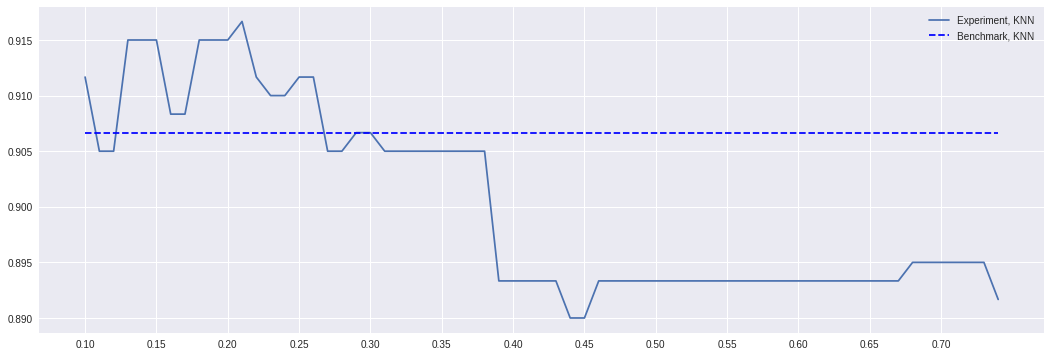

In [43]:
#Experiment on varying the STD. deviation threshold for feature filtering on KNN, k=11, 10-fold CV accuracy score

scores_k = []
std = np.arange(0.1, 0.75, 0.01)

threshold_score = cross_val_score(scale(X_train), y_train[:,1], KNN(k=11), n_splits=None, average=True, shuffle=False)
threshold_score_k = np.full(std.shape, threshold_score)

for std_threshold in std:
  new_x, cols = select_best(X_train, std_threshold)
  scores_k.append(cross_val_score(scale(new_x), y_train[:,1], KNN(k=31), n_splits=None, average=True, shuffle=False))
  
plt.figure(figsize=(18,6))
plt.plot(std, scores_k, label="Experiment, KNN")
plt.plot(std, threshold_score_k, "k--", label="Benchmark, KNN", color='blue')

plt.legend()
plt.xticks(np.arange(0.1, 0.75, 0.05))
print("Complete")

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in divide


Complete


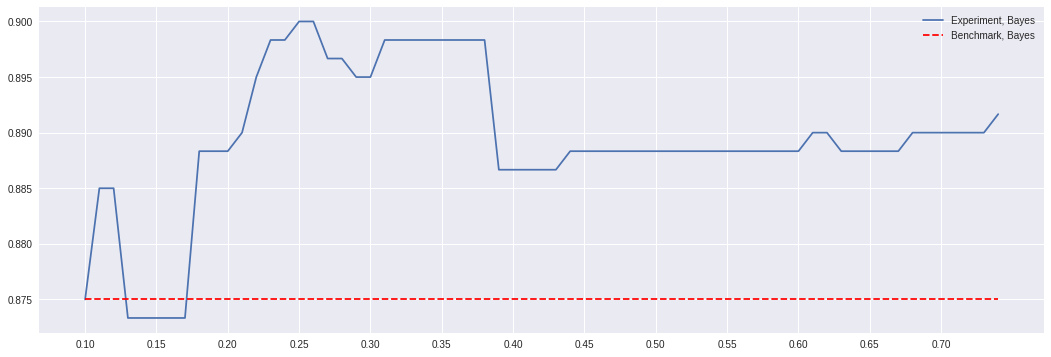

In [44]:
#Experiment on varying the STD. deviation threshold for feature filtering on NaiveBayes, 10-fold CV accuracy score

scores_b = []
std = np.arange(0.1, 0.75, 0.01)

threshold_score = cross_val_score(X_train, y_train[:,1], NaiveBayes(), n_splits=None, average=True, shuffle=True)
threshold_score_b = np.full(std.shape, threshold_score)

for std_threshold in std:
  new_x, cols = select_best(X_train, std_threshold)
  scores_b.append(cross_val_score(new_x, y_train[:,1], NaiveBayes(), n_splits=None, average=True, shuffle=True))
  
plt.figure(figsize=(18,6))
plt.plot(std, scores_b, label="Experiment, Bayes")
plt.plot(std, threshold_score_b, "k--", label="Benchmark, Bayes", color='red')
plt.legend()
plt.xticks(np.arange(0.1, 0.75, 0.05))
print("Complete")

In [45]:
#Experiment on different ways of scaling the data on different values of k, on performance of KNN, 10-fold CV accuracy score

cols = {"no scaling": X_train, "normalized": scale(X_train, center=False), "standardized":  scale(X_train, center=True)}
ks = range(1, 100, 2)
scores = {"no scaling":[], "normalized":[], "standardized":[]}

for key in cols:
  for k in ks:
    clf = KNN(k=k)
    scores[key].append(cross_val_score(cols[key], y_train[:,1], clf, n_splits=10, average=True, shuffle=False))


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


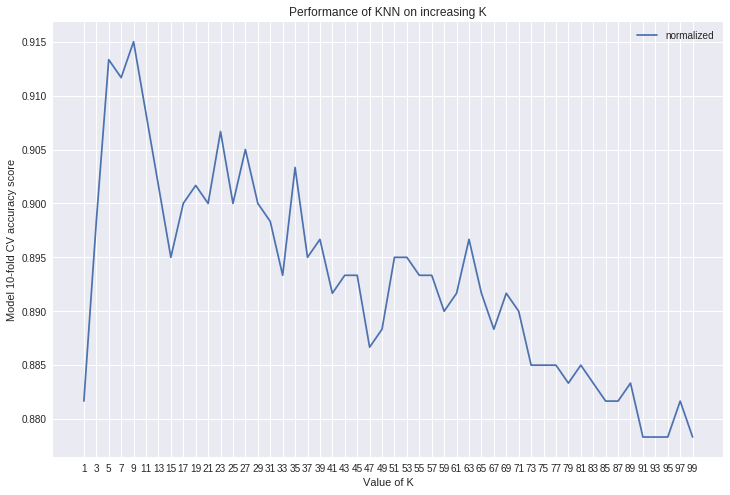

In [147]:
#Experiment on different values of k for normalized classification dataset on KNN, 10-fold CV accuracy score

plt.figure(figsize=(12,8))
plt.title("Performance of KNN on increasing K")
plt.xlabel("Value of K")
plt.ylabel("Model 10-fold CV accuracy score")
plt.xticks(range(1, 100, 2))
for score in scores:
  plt.plot(ks, scores[score], label=score)

plt.legend()

In [89]:
#Cell can be used for submission 

clf = ...
clf.fit(..., ...)
y_pred = clf.predict(..)
y_pred

array([2., 1., 2., ..., 2., 2., 2.])

In [0]:

# Arrange answer in two columns. First column (with header "Id") is an
# enumeration from 0 to n-1, where n is the number of test points. Second
# column (with header "EpiOrStroma" is the predictions.
test_header = "Id,EpiOrStroma"
n_points = X_test.shape[0]
y_pred_pp = np.ones((n_points, 2))
y_pred_pp[:, 0] = range(n_points)
y_pred_pp[:, 1] = y_pred
np.savetxt('my_submission.csv', y_pred_pp, fmt='%d', delimiter=",",
           header=test_header, comments="")

#Uncomment these for colab
from google.colab import files
files.download('my_submission.csv')
# Note: fmt='%d' denotes that all values should be formatted as integers which
# is appropriate for classification. For regression, where the second column
# should be floating point, use fmt='%d,%f'.